## Executive Summary

The task at hand was to maximize revenue from direct marketing campaigns. The data given for this task included the Social-demographical data, products owned with volumes and inflow/outflow for past 3 months. For this project Juypter Notebook has been used with various Python libraries.  

<b> Exploring data </b>: <br />To start with, the data was loaded into dataframes from all the sheets. Exploratory data analysis was done on all the social demographical data to see the diversity in data. Data for male was slightly greater than that of female along with some missing fields and the overall age varied between 0 and 100. The Current Account, Savings Account, Mutual Account, Credit card, Customer Loan and OVD counts were analysed using heat-map to see if there was any correlation betweent these features, but there was harldy any. Further, analysing the final sheet we find that Consumer Loans are the ones that are sold maximum and are responsible for accumulation of largest revenue. Consumer Loans are followed by Credit card and lastly Mutual funds.

<b> Preprocessing data </b>: <br />  Starting with the feature sex, it was converted to numerical feature by assining 0 and 1 and the missing values which were filled with 0 to balance the data. Next, the incorrect ages(where age is less than tenure) is replaced with the median of age of the set. The product acutal balances, inflow/outflow and the sales/revenue had empty entries which were replaced by 0. Then, all the dataframes were merged into one. All the entries in the Sales/Revenue (60%) were taken for training and the rest as target.

<b> Modeling</b> :
<br />
The Machine Learning Models that were considered were Random Forest and XGBoost to capture the nonlinear relationships and partial dependence of variables on the target. GridSearchCV was used on both models to find the best parameters for the algorithms and the train data was split into train/test further. MeanSquaredError was used as the performance metrics to decide on the best model. This model was then fit using the full train dataset using the best parameters.
<p />
Consumer loan, Credit card and Mutual funds all were given different subset of features to be trained on. 
For instance, to find out the propensity of availing a consumer loan, count of live consumer loans and actual consumer loans balance were removed from the independent variables. The reason is that these might have been reported after the client availed of the loan. Similarly, it was done for Credit card and mutual funds as well. 
<p />
The Consumer loan has the most sale and the highest revenues. We have trained using the full training sample with a subset of features. According to the model, the top features that contribute the most towards higher propensity and revenue are Volume_DebPayemtOrder, ActualBal_SA, Tenure, Sex, Count_OVD and Volume_Deb.
<p />
Next, in a similar way a model was trained for credit card which predicted that the top features were TransactionDeb_Card, ActBal_MF, VolumeCred_CA, VolumeDeb_PaymentOrder, Age and Age. 
Further, to decide on Mutual Funds the top features were VolumeCred_CA, VolumeCred, VolumeDeb_CA, TransactionsDeb and ActualBal_CA.
<p />
So, basically we have trained the models using all the data(60%) which included Clients who don't have any loan, credit card or mutual funds. Hence, the predictions with less revenues are the clients who probably won't be availing any of the services. This is the strategy used to maximize revenue in this case study.

<b> Results</b> :
<br />
Top 100 clients with maximum predicted revenues should be targeted. The details on the list of clients and expected revenue based on the strategy are mentioned at the bottom of this file.

## 1. Importing libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statistics
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [0]:
warnings.filterwarnings("ignore")

## 2. Loading the data

In [0]:
df_soc_dem = pd.read_excel(open("./Task_Data_Scientist_Internship_Dataset.xlsx",'rb'), sheet_name = 1)
df_prod_actBal = pd.read_excel(open("./Task_Data_Scientist_Internship_Dataset.xlsx",'rb'), sheet_name = 2)
df_inc_out = pd.read_excel(open("./Task_Data_Scientist_Internship_Dataset.xlsx",'rb'), sheet_name = 3)
df_sales_rev = pd.read_excel(open("./Task_Data_Scientist_Internship_Dataset.xlsx",'rb'), sheet_name = 4)

## 3. Exploratory Data Analysis

### Sex

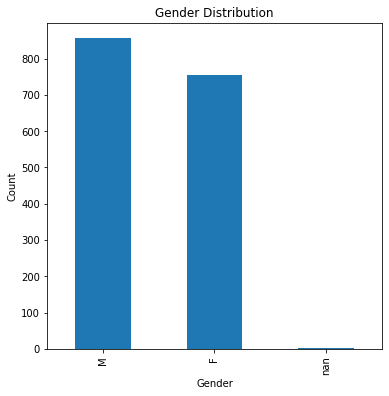

In [0]:
plt.figure(figsize=(6,6))
df_soc_dem.Sex.value_counts(dropna=False).plot.bar()
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

From the above, we can see that the dataset is slightly imbalanced and also some clients have missing value for sex.

### Age

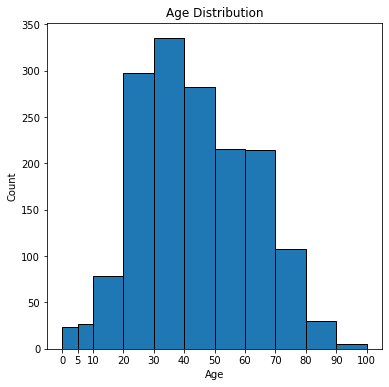

In [0]:
plt.figure(figsize=(6,6))
bins= [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.hist(df_soc_dem.Age.values, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

We can see that majority of the clients are between the age of 20 and 70. What was also interesting to see is that there are some clients who are less than 5 years old.

### Tenure

Below are the records where age is lesser than the Tenure or where the age is 0.

In [0]:
print('Client IDs')
invalid_age_list = list()
for index, row in df_soc_dem.iterrows():    
    if row.Age < (row.Tenure/12) or row.Age == 0:
        invalid_age_list.append(row.Client)
print(invalid_age_list)

Client IDs
[23, 158, 225, 300, 316, 322, 350, 391, 394, 485, 490, 509, 544, 613, 638, 648, 672, 682, 785, 851, 856, 859, 878, 961, 1044, 1056, 1063, 1082, 1160, 1169, 1231, 1241, 1256, 1372, 1403, 1409, 1427, 1431, 1493, 1499, 1529, 1561, 1569, 1583, 1586, 1591, 1615]


### Products

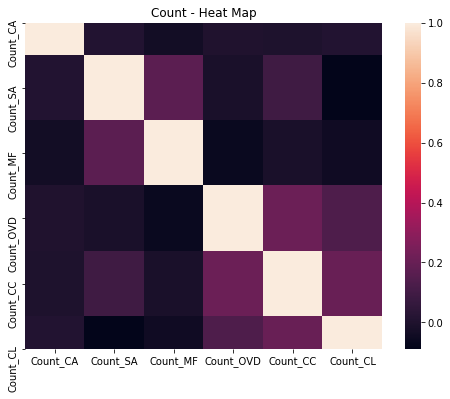

In [0]:
plt.figure(figsize=(8,6))
sns.heatmap(df_prod_actBal[['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL']].corr())
plt.title('Count - Heat Map')
plt.show()

We can see that there is not a great amount of correlation between the different products that the clients have.

### Sales and Revenue

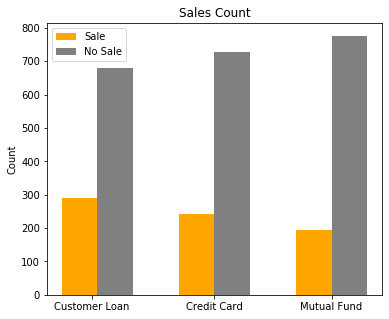

In [0]:
positions = np.array([0, 1, 2])
width = 0.3

plt.figure(figsize=(6,5))
plt.title('Sales Count')
sale_pos = [df_sales_rev.Sale_CL.sum(), df_sales_rev.Sale_CC.sum(), df_sales_rev.Sale_MF.sum()]
plt.bar(positions, sale_pos, width, color="orange")

sale_neg = [df_sales_rev.Sale_CL.count()-df_sales_rev.Sale_CL.sum(),
            df_sales_rev.Sale_CC.count()-df_sales_rev.Sale_CC.sum(), 
            df_sales_rev.Sale_MF.count()-df_sales_rev.Sale_MF.sum()]
plt.bar(positions + width, sale_neg, width, color="grey")
plt.legend(('Sale','No Sale'), loc="upper left")
plt.xticks([0.1, 1.15, 2.15] ,['Customer Loan','Credit Card','Mutual Fund'])
plt.ylabel('Count')
plt.show()

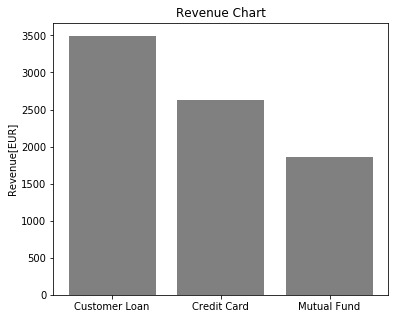

In [0]:
plt.figure(figsize=(6,5))

y_pos = np.arange(3)
rev = [df_sales_rev.Revenue_CL.sum(), df_sales_rev.Revenue_CC.sum(), df_sales_rev.Revenue_MF.sum()]

plt.bar(y_pos, rev, align='center', color="grey" )
plt.xticks(y_pos, ['Customer Loan','Credit Card','Mutual Fund'])
plt.ylabel('Revenue[EUR]')
plt.title('Revenue Chart')
plt.show()

## 4. Preprocessing 

In [0]:
# Sex
df_soc_dem = df_soc_dem.replace("F",0)
df_soc_dem = df_soc_dem.replace("M",1)

#replacing the missing sex with 0
df_soc_dem = df_soc_dem.replace(np.NaN, 0)

In [0]:
# Age and Tenure
# replacing the incorrect ages(where age is less than tenure) with the median of age
median_age = statistics.median(df_soc_dem.Age)
df_soc_dem.loc[(df_soc_dem.Age < (df_soc_dem.Tenure/12)),'Age'] = median_age

In [0]:
# Product Actual balance
df_prod_actBal = df_prod_actBal.replace(np.NaN, 0)

In [0]:
# Inflow/Outflow
df_inc_out = df_inc_out.replace(np.NaN, 0)

In [0]:
# Sales and Revenues
df_sales_rev = df_sales_rev.replace(np.NaN, 0)

#### Merging the dataframes into one

In [0]:
df = pd.merge(df_soc_dem, df_prod_actBal, how='left', left_on='Client',right_on='Client')
df = pd.merge(df, df_inc_out, how='left', left_on='Client',right_on='Client')
df = pd.merge(df, df_sales_rev, how='left', left_on='Client',right_on='Client')

Replacing the NaN values after joining the dataframe with 0s (for clients with no entry in the sales_revenue sheet).

In [0]:
df = df.replace(np.NaN, 0)

In [0]:
df.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,0.0,51,7,1,0.0,0.0,1.0,0.0,0.0,...,30.0,3.0,12.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
1,2,1.0,43,152,1,1.0,0.0,0.0,0.0,0.0,...,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,3,1.0,17,140,1,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,4,1.0,24,153,1,1.0,0.0,0.0,1.0,0.0,...,36.0,6.0,12.0,13.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,5,0.0,58,200,1,1.0,0.0,0.0,0.0,0.0,...,41.0,4.0,17.0,13.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [0]:
df.shape

(1615, 36)

Making a train and test dataframe to make predications.

In [0]:
train_df = df[df.Client.isin(df_sales_rev.Client.values)].reset_index(drop=True)

In [0]:
test_df = df[~df.Client.isin(df_sales_rev.Client.values)].reset_index(drop=True)
test_df.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,3,1.0,17,140,1,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,1.0,24,153,1,1.0,0.0,0.0,1.0,0.0,...,36.0,6.0,12.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,58,200,1,1.0,0.0,0.0,0.0,0.0,...,41.0,4.0,17.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,0.0,55,227,1,0.0,0.0,0.0,0.0,0.0,...,10.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,0.0,33,182,1,0.0,0.0,1.0,0.0,0.0,...,7.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Model building

### Consumer Loans

In [0]:
X_cl = train_df[['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']]

y_cl = train_df[['Revenue_CL']]

X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, test_size=0.20, random_state=42)

scaler = MinMaxScaler()
X_train_cl_scaled = scaler.fit_transform(X_train_cl)
X_test_cl_scaled = scaler.transform(X_test_cl)

#### XGBoost

In [0]:
params = {'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5],
          'n_estimators': [10, 50, 100]
         }

clf_xgb = GridSearchCV(xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, nthread=-1),
                   params)
clf_xgb.fit(X_train_cl_scaled, y_train_cl)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.2,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha...,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5

In [0]:
print('Mean Squared Error - XGBoost: ',
      np.mean((y_test_cl['Revenue_CL'].values - clf_xgb.predict(X_test_cl_scaled))**2))

Mean Squared Error - XGBoost:  39.76715051132458


#### RandomForest

In [0]:
param_grid = {
    "n_estimators": [10, 50, 100, 150, 200],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": [2,4,8],
    'max_depth': range(3,7)
}

clf_rf = GridSearchCV(RandomForestRegressor(),param_grid, n_jobs=-1)

clf_rf.fit(X_train_cl_scaled, y_train_cl)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [0]:
print('Mean Squared Error - RandomForest: ',
      np.mean((y_test_cl['Revenue_CL'].values - clf_rf.predict(X_test_cl_scaled))**2))

Mean Squared Error - RandomForest:  37.58752144914849


#### Since, MSE is almose the same for  both models we use XGBoost to make predictions.

In [0]:
clf_xgb.best_params_

{'colsample_bytree': 0.8,
 'gamma': 5,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 10,
 'subsample': 1.0}

Fitting the model with the best parameters.

In [0]:
cl_model = xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, nthread=-1,
                             colsample_bytree= 0.8, gamma= 5, max_depth= 5,
                             min_child_weight= 10, n_estimators= 10, subsample= 1) 

cl_model.fit(X_train_cl_scaled, y_train_cl)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=5,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=10, missing=None, n_estimators=10,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

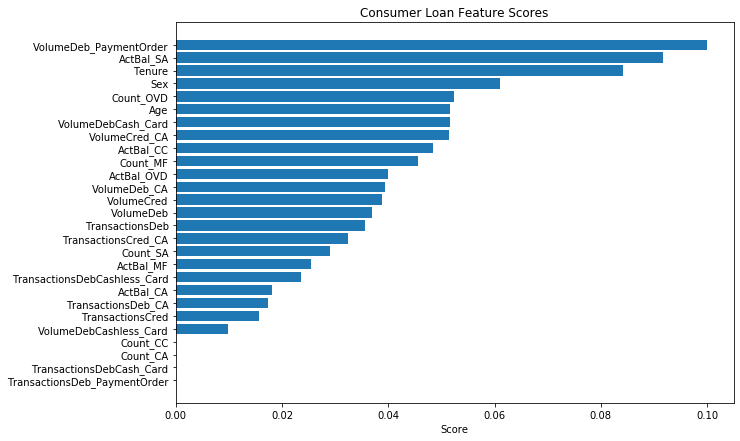

In [0]:
cl_imp_df = pd.DataFrame({'Feature':X_cl.columns,
                          'Feature Score': cl_model.feature_importances_})
cl_imp_df = cl_imp_df.sort_values(by=['Feature Score'])

plt.figure(figsize=(10,7))
plt.barh(cl_imp_df['Feature'], cl_imp_df['Feature Score'])
plt.title('Consumer Loan Feature Scores')
plt.xlabel('Score')
plt.show()

In [0]:
cl_model.fit(X_cl, y_cl)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=5,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=10, missing=None, n_estimators=10,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
cl_model_pred = cl_model.predict(test_df[['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']])

cl_model_df = pd.DataFrame({
    'Client':  test_df.Client.values,
    'Revenue_CL':  cl_model_pred
}).sort_values('Revenue_CL', ascending= False)

cl_model_df.head(10)

,Client,Revenue_CL
275,674,12.473426
582,1455,10.863647
589,1474,10.516529
335,828,10.444112
287,706,10.444112
228,541,10.263537
89,217,9.641533
546,1365,9.408599
360,889,9.287312
61,151,9.188388


### Credit Card

In [0]:
X_cc = train_df[['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']]

y_cc = train_df[['Revenue_CC']]

X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_cc, y_cc, test_size=0.20, random_state=42)

X_train_cc_scaled = scaler.fit_transform(X_train_cc)
X_test_cc_scaled = scaler.transform(X_test_cc)

#### XGBoost

In [0]:
params = {'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5],
          'n_estimators': [10, 50, 100]
         }

clf_xgb = GridSearchCV(xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, nthread=-1),
                   params)
clf_xgb.fit(X_train_cc_scaled, y_train_cc)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.2,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha...,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5

In [0]:
print('Mean Squared Error - XGBoost: ',
      np.mean((y_test_cc['Revenue_CC'].values - clf_xgb.predict(X_test_cc_scaled))**2))

Mean Squared Error - XGBoost:  902.9424214728296


#### RandomForest

In [0]:
param_grid = {
    "n_estimators": [10, 50, 100, 150, 200],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": [2,4,8],
    'max_depth': range(3,7)
}

clf_rf = GridSearchCV(RandomForestRegressor(), param_grid, n_jobs=-1)

clf_rf.fit(X_train_cc_scaled, y_train_cc)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [0]:
print('Mean Squared Error - RandomForest: ',
      np.mean((y_test_cc['Revenue_CC'].values - clf_rf.predict(X_test_cc_scaled))**2))

Mean Squared Error - RandomForest:  897.2402102788928


#### Since, MSE is almose the same for  both models we use XGBoost to make predictions.

In [0]:
clf_xgb.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.5,
 'max_depth': 3,
 'min_child_weight': 10,
 'n_estimators': 10,
 'subsample': 1.0}

Fitting the model with the best parameters.

In [0]:
cc_model = xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, nthread=-1,
                             colsample_bytree= 0.6, gamma= 0.5, max_depth= 5,
                             min_child_weight= 10, n_estimators= 10, subsample= 0.8) 

cc_model.fit(X_train_cc_scaled, y_train_cc)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=10, missing=None, n_estimators=10,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

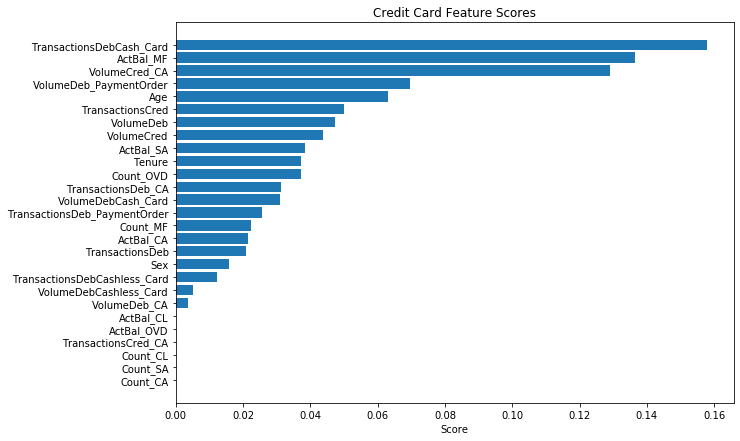

In [0]:
cc_imp_df = pd.DataFrame({'Feature':X_cc.columns,
                          'Feature Score': cc_model.feature_importances_})
cc_imp_df = cc_imp_df.sort_values(by=['Feature Score'])

plt.figure(figsize=(10,7))
plt.barh(cc_imp_df['Feature'], cc_imp_df['Feature Score'])
plt.title('Credit Card Feature Scores')
plt.xlabel('Score')
plt.show()

In [0]:
cc_model.fit(X_cc, y_cc)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=10, missing=None, n_estimators=10,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [0]:
cc_model_pred = cc_model.predict(test_df[['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']])

cc_model_df = pd.DataFrame({
    'Client':  test_df.Client.values,
    'Revenue_CC':  cc_model_pred
}).sort_values('Revenue_CC', ascending= False)

cc_model_df.head()

,Client,Revenue_CC
585,1460,34.038891
425,1071,27.981695
371,919,23.403709
214,516,22.088434
50,126,18.685383


### Mutual Fund

In [0]:
X_mf = train_df[['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_CL',
       'Count_OVD', 'Count_CC', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']]

y_mf = train_df[['Revenue_MF']]

X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, test_size=0.20, random_state=42)

X_train_mf_scaled = scaler.fit_transform(X_train_mf)
X_test_mf_scaled = scaler.transform(X_test_mf)

#### XGBoost

In [0]:
params = {'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5],
          'n_estimators': [10, 50, 100]
         }

clf_xgb = GridSearchCV(xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, nthread=-1),
                   params)
clf_xgb.fit(X_train_mf_scaled, y_train_mf)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.2,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha...,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5

In [0]:
print('Mean Squared Error - XGBoost: ',
      np.mean((y_test_mf['Revenue_MF'].values - clf_xgb.predict(X_test_mf_scaled))**2))

Mean Squared Error - XGBoost:  57.33297722277491


#### RandomForest

In [0]:
param_grid = {
    "n_estimators": [10, 50, 100, 150, 200],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": [2,4,8],
    'max_depth': range(3,7)
}

clf_rf = GridSearchCV(RandomForestRegressor(), param_grid, n_jobs=-1)

clf_rf.fit(X_train_mf_scaled, y_train_mf)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [0]:
print('Mean Squared Error - RandomForest: ',
      np.mean((y_test_mf['Revenue_MF'].values - clf_rf.predict(X_test_mf_scaled))**2))

Mean Squared Error - RandomForest:  56.62118604383751


#### Since, MSE is almose the same for  both models we use RandomForest to make predictions.

In [0]:
clf_rf.best_params_

{'max_depth': 3,
 'max_features': 'log2',
 'min_samples_split': 8,
 'n_estimators': 100}

Fitting the model with the best parameters.

In [0]:
mf_model = RandomForestRegressor(max_depth= 3, max_features= 'log2',
                             min_samples_split= 2, n_estimators= 150)

mf_model.fit(X_train_mf_scaled, y_train_mf)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

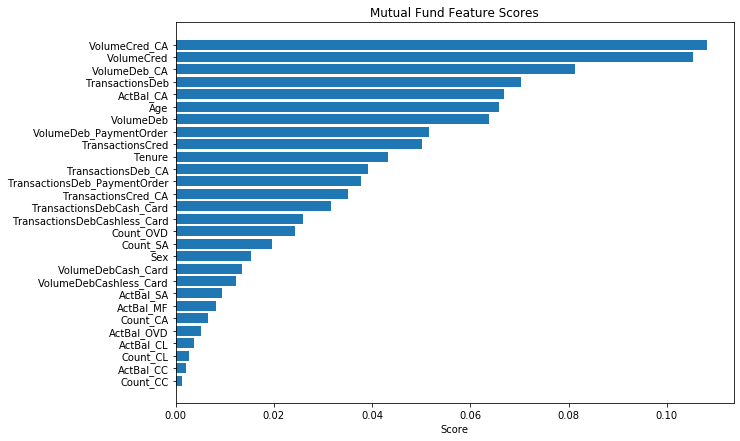

In [0]:
mf_imp_df = pd.DataFrame({'Feature':X_mf.columns,
                          'Feature Score': mf_model.feature_importances_})
mf_imp_df = mf_imp_df.sort_values(by=['Feature Score'])

plt.figure(figsize=(10,7))
plt.barh(mf_imp_df['Feature'], mf_imp_df['Feature Score'])
plt.title('Mutual Fund Feature Scores')
plt.xlabel('Score')
plt.show()

In [0]:
mf_model.fit(X_mf, y_mf)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
mf_model_pred = mf_model.predict(test_df[['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_CL',
       'Count_OVD', 'Count_CC', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']])

mf_model_df = pd.DataFrame({
    'Client':  test_df.Client.values,
    'Revenue_MF':  mf_model_pred
}).sort_values('Revenue_MF', ascending= False)

mf_model_df.head()

,Client,Revenue_MF
606,1508,22.817241
223,532,20.732315
308,766,15.094122
136,330,13.450985
248,596,13.176596


## 6. Results

### Consumer Loan

Below is list of cliets who if offered a consumer loan have higher propensity to buy and generate the most revenues.

In [0]:
cl_model_df['Client'].values[:100]

array([ 674, 1455, 1474,  828,  706,  541,  217, 1365,  889,  151, 1096,
       1599, 1530,  331,  697,  389,  498, 1510,  532, 1349,  779,  330,
       1343,  731,  886,  786,  948,  342,  454,  878, 1119,  504, 1110,
       1192,  535,    4,  347,  978, 1031,  715,  844, 1077,  224,  350,
       1491, 1225, 1252, 1097,  265, 1073, 1321,  117, 1611,  111, 1210,
         84,  126,  485,  524,  206,  710, 1443,  607,  164, 1185,  155,
        923, 1332,  940,  240,  701,  231, 1123, 1289,    7,  695,  373,
        459,  228,  975, 1186,  699, 1341,  868,  750,  314, 1497,  728,
       1358, 1356, 1360, 1063, 1051,  832,  474,  243, 1594,   89,    9,
        329])

In [0]:
print('The expected total revenue generated if the above clients accept the loan is: EUR',
      round(cl_model_df['Revenue_CL'].values[:100].sum(), 3)) 

The expected total revenue generated if the above clients accept the loan is: EUR 651.298


### Credit Card

Below is list of cliets who if offered a credit card have higher propensity to buy credit card and generate the most revenues.

In [0]:
cc_model_df['Client'].values[:100]

array([1460, 1071,  919,  516,  126, 1263, 1162,  383,  541, 1480,  381,
         84, 1365,  727,  350,  401,  431,  336,  166,  243, 1374, 1443,
        931, 1550,  583,  467,  866,  331, 1511, 1296,  620,  496,  803,
        828,  153,  996, 1107,  596, 1389,  958,  373, 1262, 1457,  484,
       1051,  641, 1077, 1510, 1278, 1080, 1064,  951,  555,  168,  842,
       1503,  794,  174, 1455, 1002,  505,  715,  196,  521, 1037,   99,
       1240,   97,  965,    7,  463,  954, 1494,  592,  368, 1599, 1398,
        798,  706,  488, 1324,  389,  923,  957,  543,  851, 1594,  347,
        799,  813,  532, 1192, 1343,  128, 1349,  570, 1410, 1134,  355,
       1139])

In [0]:
print('The expected total revenue generated if the above clients accept credit card is: EUR',
      round(cc_model_df['Revenue_CC'].values[:100].sum(), 3)) 

The expected total revenue generated if the above clients accept credit card is: EUR 1024.392


### Mutual Fund

Below is list of cliets who if offered a credit card have higher propensity to buy mutual fund and generate the most revenues.

In [0]:
mf_model_df['Client'].values[:100]

array([1508,  532,  766,  330,  596,  217,  110, 1098, 1093,  785,  392,
       1008, 1051,  313, 1541,  566, 1468,  839,   51,  505, 1445, 1599,
       1200,  196, 1373, 1510,  307,  224,  265, 1145,  530,  197,  216,
       1207,  463,  707,  929, 1518,   84,  541,  835,  211,  411, 1380,
        314, 1610,  239,  153, 1132, 1410,  668,  206,  522,  543, 1077,
       1119,  362,  748, 1107,  381,  200,  697, 1478,  368,  813, 1146,
        616,  309, 1071, 1458, 1546,  379,  188, 1604, 1251,   57,  957,
       1134, 1243, 1457,  940, 1343,  799, 1026,  383,  394,  358,  779,
         64,  583,  243,  375, 1226, 1289, 1358,  796, 1112, 1588, 1390,
        936])

In [0]:
print('The expected total revenue generated if the above clients buy mutual fund is: EUR', 
      round(mf_model_df['Revenue_MF'].values[:100].sum(),3)) 

The expected total revenue generated if the above clients buy mutual fund is: EUR 430.988
